In [149]:
import collections, matplotlib
from lung import volume_from_pressure, pressure_from_volume
import pandas as pd, numpy as np, matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10,7]

pd.set_option('precision', 4)

"""
							In men 	In women
				Vital capacity 	4.8 	3.1 	IRV + TV + ERV
		Inspiratory capacity 	3.8 	2.4 	IRV + TV
Functional residual capacity 	2.4 	1.8 	ERV + RV
		Total lung capacity 	6.0 	4.2 	IRV + TV + ERV + RV 
"""
Patient_log = collections.namedtuple(
    'Patient_log', 
    ['time', 'pressure_mouth', 'pressure_alveolus', 'pressure_intrapleural', 'lung_volume', 'flow'])

class Patient:
    def __init__(self, 
                 height = 175, #cm
                 weight = 70, #kg
                 sex = 'M', # M or other
                 pressure_mouth = 0, #cmH2O
                 resistance = 10 # cmh2o/l/s or cmh2o per ml/ms
                ):
        self.time = 0 # miliseconds
        self.height = height
        self.weight = weight
        self.sex = sex
        self.TLC = 6000 if sex == 'M' else 4200 # todo calculate on age, height weight
        self.pressure_mouth = pressure_mouth
        self.resistance = resistance
        self.pressure_alveolus = pressure_mouth # start at equlibrium
        v_percent = volume_from_pressure(self.pressure_alveolus, 'Total') #assuming no resp effort
        self.lung_volume = self.TLC * v_percent / 100
        self.pressure_intrapleural = pressure_from_volume(v_percent, 'Chest')
        self.flow = 0
        self.log = []
    
    def status(self):
        return Patient_log(self.time, self.pressure_mouth, self.pressure_alveolus, self.pressure_intrapleural, self.lung_volume, self.flow)
            
    def advance(self, advance_time = 200, pressure_mouth = 0):
        self.time = self.time + advance_time # miliseconds
        self.pressure_mouth = pressure_mouth
        gradient = pressure_mouth - self.pressure_alveolus 
        self.flow = gradient / self.resistance # l/second or ml/ms
        self.lung_volume += self.flow * advance_time
        v_percent = self.lung_volume * 100 / self.TLC
        self.pressure_alveolus = pressure_from_volume(v_percent, "Total")
        self.pressure_intrapleural = pressure_from_volume(v_percent, "Chest")
        status = self.status()
        self.log.append(status)
        return status
        
        
Ventilator_log = collections.namedtuple('Ventilator_log', ['time', 'phase', 'pressure', 'pressure_mouth'])
class Ventilator:
    def __init__(self, mode = "PCV", Pi = 15, PEEP = 5, rate = 10, IE=0.5):
        self.pressure = 0
        self.pressure_mouth = 0
        self.mode = mode
        self.Pi = Pi
        self.mode = mode
        self.PEEP = PEEP
        self.rate = rate
        self.IE = IE
        self.phase = "E"
        self.log = []
        self.time = 0 # miliseconds
    
    def target_pressure(self):
        return self.PEEP if self.phase == "E" else self.Pi
    
    def status(self):
        return Ventilator_log(self.time, self.phase, self.pressure, self.pressure_mouth)
    
    def advance(self, advance_time = 200, pressure_mouth = 0):
        self.time = self.time + advance_time # miliseconds
        self.pressure_mouth = pressure_mouth # cmH2O
        # set phase
        breath_length = 60000 / self.rate # milliseconds
        time_since_inspiration_began = self.time % breath_length
        inspiration_length = breath_length * self.IE / (self.IE + 1)
        new_phase = "I" if time_since_inspiration_began < inspiration_length else "E"
        if new_phase != self.phase:
            self.phase = new_phase
            self.pressure = self.target_pressure()
            self.pressure_mouth = self.pressure # assume perfect ventilator
        status = self.status()
        self.log.append(status)
        return status

In [160]:
def plots(pdf, title):
    fig, plots = plt.subplots(3, sharex=True) # , gridspec_kw={'hspace': 0}
    (ax1, ax2, ax3) = plots
    for ax in plots:
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plots[-1].spines['bottom'].set_visible(True)
        
    fig.suptitle(title)
    ax1.plot(pdf['time'] / 1000, pdf['flow'], 'dimgray')
    ax1.plot(pdf['time'] / 1000, pdf['flow_i'], 'tab:orange')
    ax1.plot(pdf['time'] / 1000, pdf['flow_e'], 'tab:blue')

    ax1.set(ylabel = 'Flow (l/s)')
    ax2.plot(pdf['time'] / 1000, pdf['pressure_mouth'], 'dimgray')
    ax2.plot(pdf['time'] / 1000, pdf['pressure_1'], 'tab:green')
    ax2.plot(pdf['time'] / 1000, pdf['pressure_2'], 'tab:green')

    ax2.set(ylabel = 'P (cmH2O)')
    ax3.plot(pdf['time'] / 1000, pdf['lung_volume'], 'tab:orange')
    ax3.set(ylabel = 'Volume (ml)', xlabel = 'time (seconds)')
    ax1.label_outer()
    ax2.label_outer()
    plt.show()
    
def run(patient, ventilator, start_time = 0, end_time = 20000, time_resolution = 50):
    # print('starting', patient.status())
    patient_status = patient.advance(advance_time = 0)
    # print('vent starting', ventilator.status())
    for current_time in range(start_time, end_time, time_resolution): 
        ventilator_status = ventilator.advance(advance_time = time_resolution, pressure_mouth = patient_status.pressure_mouth)
        patient_status = patient.advance(advance_time = time_resolution, pressure_mouth = ventilator_status.pressure_mouth)
    df = pd.DataFrame.from_records(patient.log, columns=Patient_log._fields)
    return df

In [164]:
def run_and_output(s):
    print(s)
    p = Patient(resistance=s['resistance'], pressure_mouth=s['PEEP'])
    v = Ventilator(PEEP=s['PEEP'], rate=s['rate'], IE=s['IE'], Pi = s['Pi'])
    pdf = run(p, v, end_time = s['end_time'] * 1000, time_resolution=s['time_resolution'])
    pdf['flow'] += np.random.normal(0, s['flow_noise_sd'], len(pdf))
    wave_length = s['heart_rate'] * np.pi * 2 / 60 
    pdf['flow'] += np.sin(pdf['time'] * wave_length / 1000) * s['cardiac_amplitude']
    pdf['pressure_1'] = pdf['pressure_mouth'] + np.random.normal(0, s['pressure_noise_sd'], len(pdf)) #
    pdf['pressure_2'] = pdf['pressure_mouth'] + np.random.normal(0, s['pressure_noise_sd'], len(pdf)) #
    pdf['flow_i'] = pdf['flow'].clip(lower=0) + np.random.normal(0, s['flow_noise_sd'], len(pdf))
    pdf['flow_e'] = pdf['flow'].clip(upper=0) + np.random.normal(0, s['flow_noise_sd'], len(pdf))
    plots(pdf, title=s['title'])
    return pdf


{'title': 'Cardiac 60', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 500, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 60, 'cardiac_amplitude': 0.1}


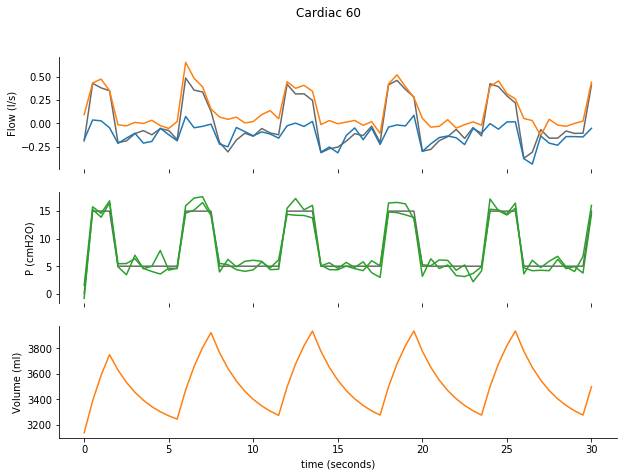

{'title': 'Cardiac 30', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 500, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 30, 'cardiac_amplitude': 0.1}


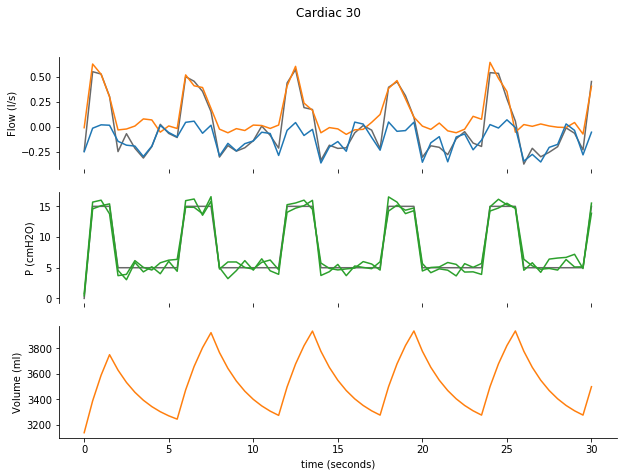

{'title': 'Cardiac 120', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 500, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 120, 'cardiac_amplitude': 0.1}


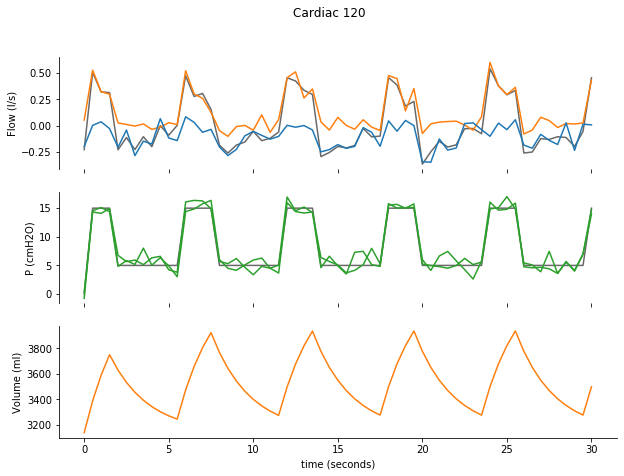

{'title': 'Base', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


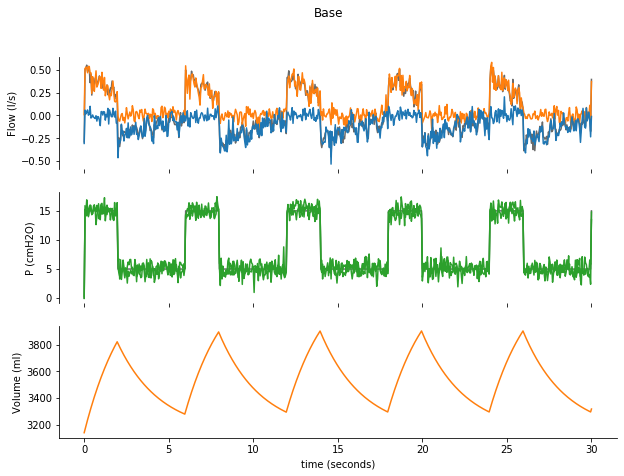

{'title': 'High Resistance', 'resistance': 80, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


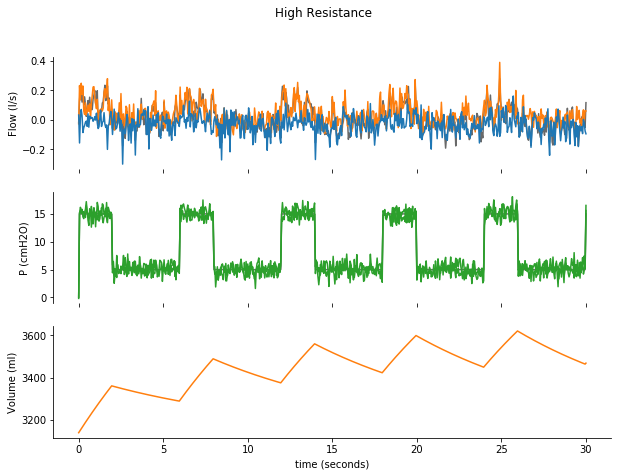

{'title': 'Low Pressure', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 7, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


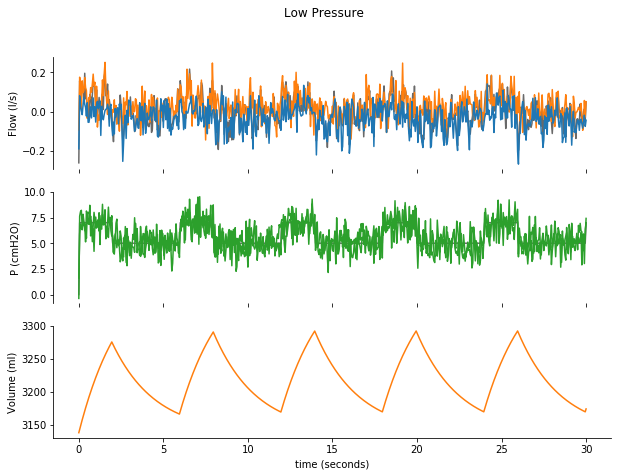

{'title': 'Wimpy', 'resistance': 20, 'PEEP': 7, 'IE': 0.5, 'Pi': 10, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


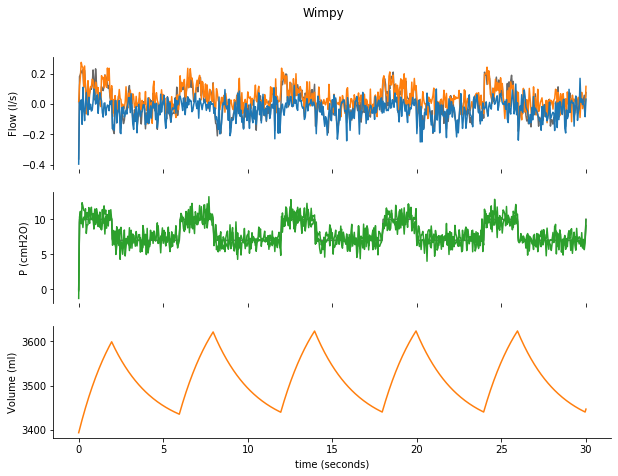

{'title': 'High Pressure', 'resistance': 20, 'PEEP': 14, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


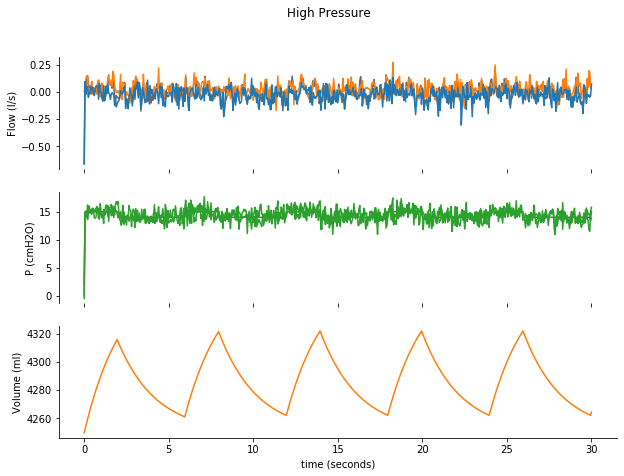

{'title': 'Stuck High', 'resistance': 20, 'PEEP': 14, 'IE': 0.5, 'Pi': 14, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


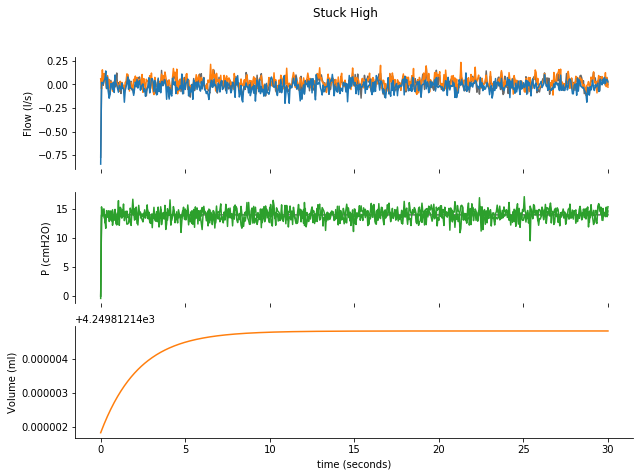

{'title': 'Crazy fast', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 60, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


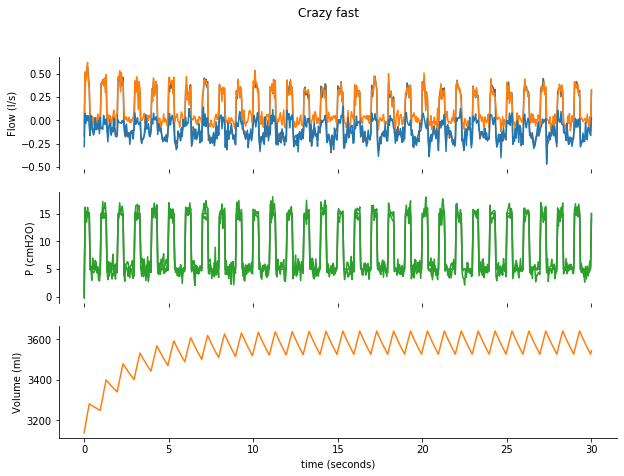

{'title': 'Too slow', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 3, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


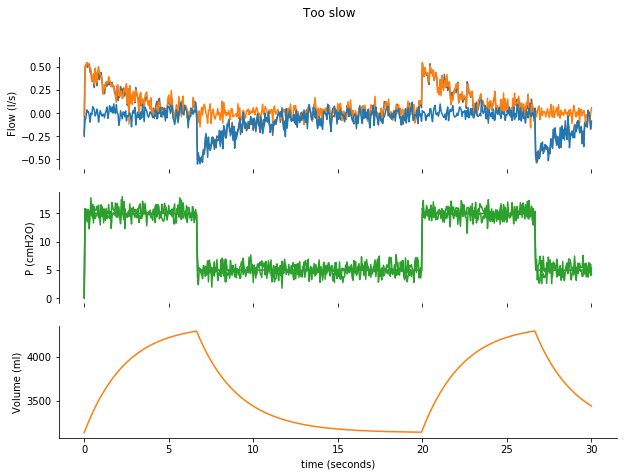

{'title': 'No expiration time', 'resistance': 20, 'PEEP': 5, 'IE': 5, 'Pi': 15, 'rate': 12, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


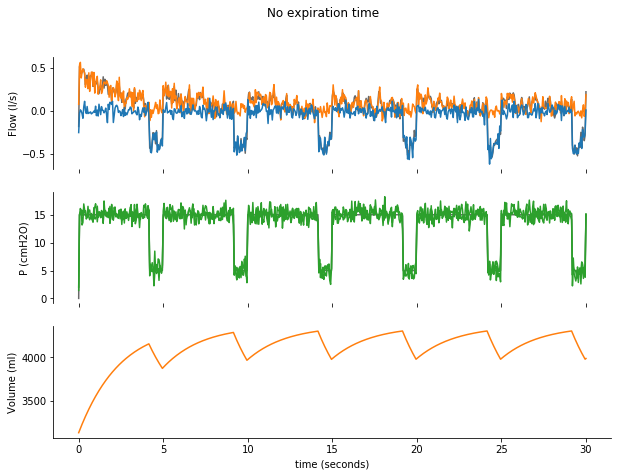

In [165]:
base_scenario = dict(
    title = 'Base',
    resistance = 20,
    PEEP = 5,
    IE = 0.5,
    Pi = 15,
    rate = 10,
    end_time = 30,
    time_resolution = 50,
    flow_noise_sd = 0.05,
    pressure_noise_sd = 1,
    heart_rate = 85,
    cardiac_amplitude = 0.05
)
e= 30
r= 500
c= 0.1
scenarios = [
    dict(base_scenario, title='Cardiac 60', cardiac_amplitude = c, end_time = e, heart_rate = 60, time_resolution = r),
    dict(base_scenario, title='Cardiac 30', cardiac_amplitude = c, end_time = e, heart_rate = 30, time_resolution = r),
    dict(base_scenario, title='Cardiac 120', cardiac_amplitude = c, end_time = e, heart_rate = 120, time_resolution = r),
    base_scenario,
    dict(base_scenario, title='High Resistance', resistance = 80),
    dict(base_scenario, title='Low Pressure', Pi = 7),
    dict(base_scenario, title='Wimpy', PEEP = 7, Pi=10),
    dict(base_scenario, title='High Pressure', PEEP = 14),
    dict(base_scenario, title='Stuck High', PEEP = 14, Pi = 14),
    dict(base_scenario, title='Crazy fast', rate = 60),   
    dict(base_scenario, title='Too slow', rate = 3),   
    dict(base_scenario, title='No expiration time', rate = 12, IE = 5),   
]
for s in scenarios:
    run_and_output(s)

{'title': 'Base', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


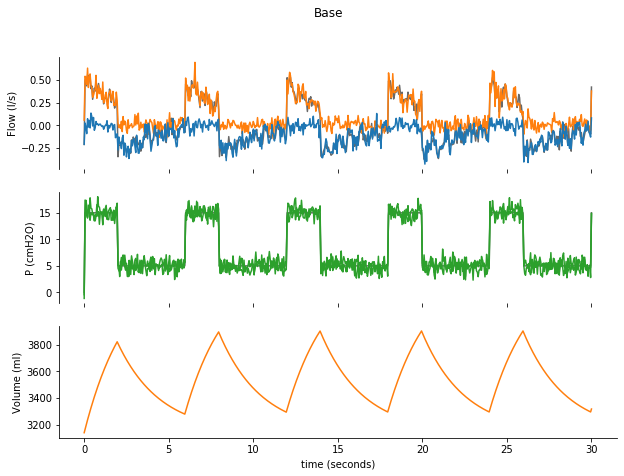

[{"event":"M","type":"P","loc":"I","ms":0,"val":-1},{"event":"M","type":"P","loc":"E","ms":0,"val":0},{"event":"M","type":"F","loc":"I","ms":0,"val":3409},{"event":"M","type":"F","loc":"E","ms":0,"val":-12519},{"event":"M","type":"P","loc":"I","ms":50,"val":17},{"event":"M","type":"P","loc":"E","ms":50,"val":15},{"event":"M","type":"F","loc":"I","ms":50,"val":32308},{"event":"M","type":"F","loc":"E","ms":50,"val":1477},{"event":"M","type":"P","loc":"I","ms":100,"val":16},{"event":"M","type":"P","loc":"E","ms":100,"val":17},{"event":"M","type":"F","loc":"I","ms":100,"val":31338},{"event":"M","type":"F","loc":"E","ms":100,"val":-1316},{"event":"M","type":"P","loc":"I","ms":150,"val":14},{"event":"M","type":"P","loc":"E","ms":150,"val":16},{"event":"M","type":"F","loc":"I","ms":150,"val":26976},{"event":"M","type":"F","loc":"E","ms":150,"val":-5513},{"event":"M","type":"P","loc":"I","ms":200,"val":14},{"event":"M","type":"P","loc":"E","ms":200,"val":14},{"event":"M","type":"F","loc":"I","

In [167]:
"""
To do: create a PIRDS JSON file.

The Types are:

    P : Pressure: cm H2O (a medical standard) times 10
    F : Flow slm (liters at 0C per minute) times 1000


{ "event" : "M",
  "type" : "T",
  "loc" : "B",
  "num" : 2,
  "ms" : 35,
  "val" : 250
  }
"""
Patient_log = collections.namedtuple(
    'Patient_log', 
    ['time', 'pressure_mouth', 'pressure_alveolus', 'pressure_intrapleural', 'lung_volume', 'flow'])

def df_to_PIRDS(df):
    pirds = []
    for index, r in df.iterrows():
        pirds.append({"event": "M",
                      "type": "P", "loc":"I", 
                      "ms": int(r.time), "val": int(round(r.pressure_1))})
        pirds.append({"event": "M",
                      "type": "P", "loc":"E", 
                      "ms": int(r.time), "val": int(round(r.pressure_2))})
        pirds.append({"event": "M",
                      "type": "F", "loc":"I", 
                      "ms": int(r.time), "val": int(round(r.flow_i * 60 * 1000))})
        pirds.append({"event": "M",
                      "type": "F", "loc":"E", 
                      "ms": int(r.time), "val": int(round(r.flow_e * 60 * 1000))})
    return pd.DataFrame.from_records(pirds)
pdf = run_and_output(base_scenario)        
print(df_to_PIRDS(pdf.head()).to_json(orient="records"))

In [ ]:
pdf = run_and_output(base_scenario)

In [78]:
f = pdf.head(5).to_json(orient='records')

In [210]:
import importlib

In [223]:
import VentOSSP
import dataclasses

In [248]:
importlib.reload(VentOSSP)
vs = VentOSSP.VentilatorStatus()
config = VentOSSP.VentilatorConfig()
p = 5
print(config)
print(vs)
VentOSSP.smooth(config, vs, p)
print(vs)

VentilatorConfig(alphaA=0.9, alphaR=0.99, alphaS=0.9, sample_frequency=10)
VentilatorStatus(p=0, vhigh=0, vlow=0, Vhigh=0, Vlow=0, Thigh=0, Tlow=0, Tpeak=0, PIP=0, PEEP=0, RR=0, inhaling=False)
VentilatorStatus(p=5, vhigh=0.4999999999999999, vlow=0.050000000000000044, Vhigh=5, Vlow=0, Thigh=0, Tlow=1, Tpeak=1, PIP=0, PEEP=0.0, RR=0, inhaling=True)


{'title': 'Base', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 120, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05}


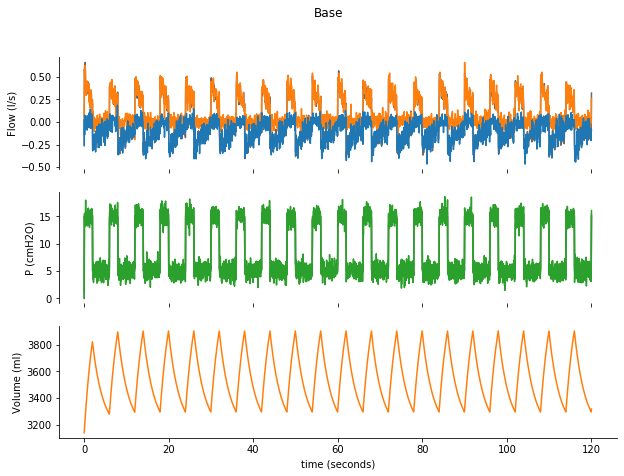

In [255]:
sample_frequency = 20
sim = run_and_output(dict(base_scenario, time_resolution = round(1000/sample_frequency), end_time = 120))

In [262]:
config = VentOSSP.VentilatorConfig()
config.sample_frequency = sample_frequency 
vs = VentOSSP.VentilatorStatus()
sp = [] # container for processed signals
for i, trace in sim.iterrows():
    p = trace.pressure_1
    t = trace.time
    VentOSSP.smooth(config, vs, p)
    sp.append(dict(dataclasses.asdict(vs), time=t))
results = pd.DataFrame.from_records(sp)
results['time_s'] = results['time'] / 1000
results['phase'] = results['inhaling'].astype(int) * 10 + 5

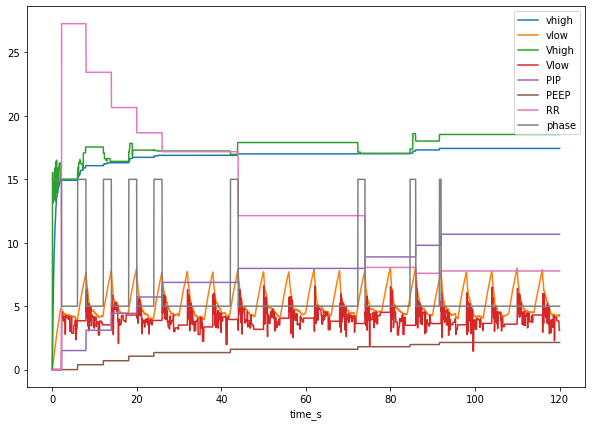

In [264]:
results.plot(x='time_s', y=[#'p', 
                            'vhigh', 'vlow', 'Vhigh', 'Vlow', 
                          # 'Thigh', 'Tlow', 'Tpeak',
                          'PIP', 'PEEP', 'RR', 'phase'])